In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

# Load data
data = pd.read_csv('overallhomedata.csv')

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Feature engineering
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['elapsed_time'] = data['timestamp'].diff().dt.total_seconds().fillna(0)

# Define feature types
categorical_features = ['event', 'element', 'page']
numerical_features = ['hour', 'day_of_week', 'x', 'y', 
                      'timeSpent', 'scroll', 'depth', 
                      'timeSpentOnHover', 'elapsed_time']

# Select features
features = categorical_features + numerical_features
X = data[features]

# Define the preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Use 'median' if preferred
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(X_preprocessed)

# Predict anomalies
data['anomaly'] = iso_forest.predict(X_preprocessed)
# In Isolation Forest, -1 indicates anomaly and 1 indicates normal

# Extract anomalies
anomalies = data[data['anomaly'] == -1]

# Output anomalies
print("Number of anomalies detected:", anomalies.shape[0])
print(anomalies)


Number of anomalies detected: 11
    ip_address  event                  element  \
1    127.0.0.1  hover          Bhuvan Lite Box   
7    127.0.0.1  hover  Bhuvan Data Archive Box   
8    127.0.0.1  hover  Bhuvan Data Archive Box   
9    127.0.0.1  hover  Bhuvan Data Archive Box   
52   127.0.0.1  hover            Bhuvan 2D Box   
53   127.0.0.1  click              Maps Button   
54   127.0.0.1  click                   BUTTON   
126  127.0.0.1  click          Services Button   
128  127.0.0.1  click          Services Button   
130  127.0.0.1  click          Services Button   
132  127.0.0.1  click          Services Button   

                           timestamp       x      y          page  \
1   2024-10-07 05:57:00.125000+00:00   821.0  342.0  info-section   
7   2024-10-07 05:57:20.541000+00:00  1185.0  357.0  info-section   
8   2024-10-07 05:57:20.574000+00:00  1225.0  440.0  info-section   
9   2024-10-07 05:57:20.591000+00:00  1229.0  471.0  info-section   
52  2024-10-07 05:59:

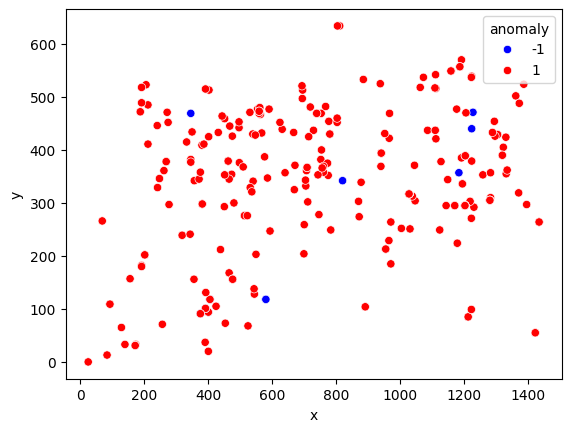

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plotting a pair of features
sns.scatterplot(x=data['x'], y=data['y'], hue=data['anomaly'], palette=['blue', 'red'])
plt.show()


In [5]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
data['anomaly_lof'] = lof.fit_predict(X_preprocessed)
anomalies_lof = data[data['anomaly_lof'] == -1]


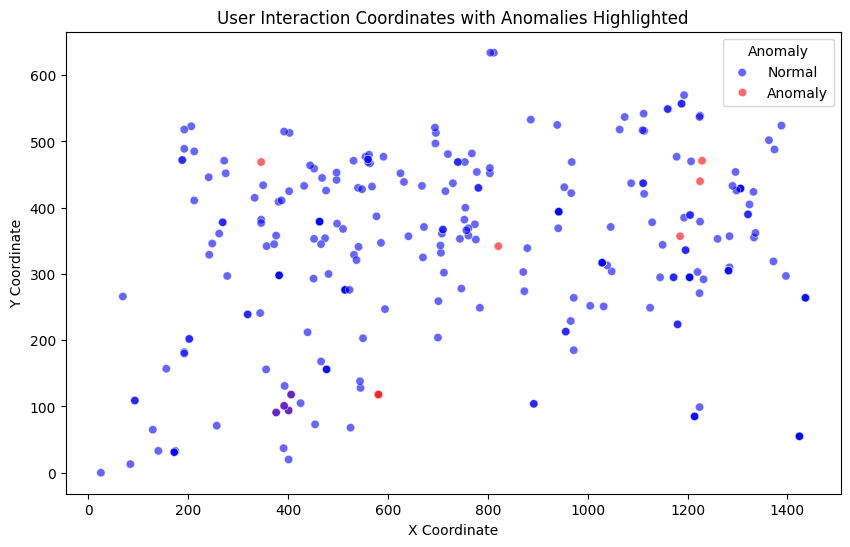

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of x vs y
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='x', y='y', hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title('User Interaction Coordinates with Anomalies Highlighted')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()


C:\Users\Hp\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


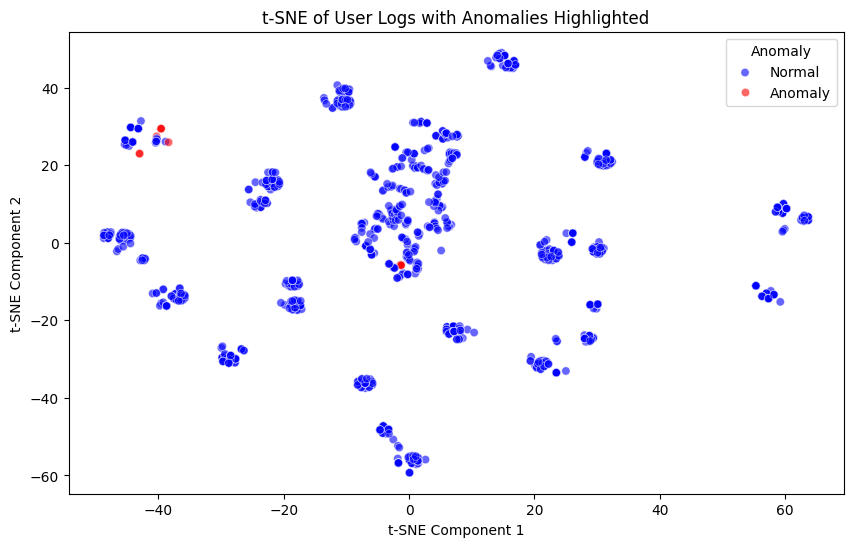

In [9]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed)

# Add t-SNE components to the DataFrame
data['tSNE1'] = X_tsne[:, 0]
data['tSNE2'] = X_tsne[:, 1]

# Scatter plot of t-SNE components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='tSNE1', y='tSNE2', hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title('t-SNE of User Logs with Anomalies Highlighted')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()


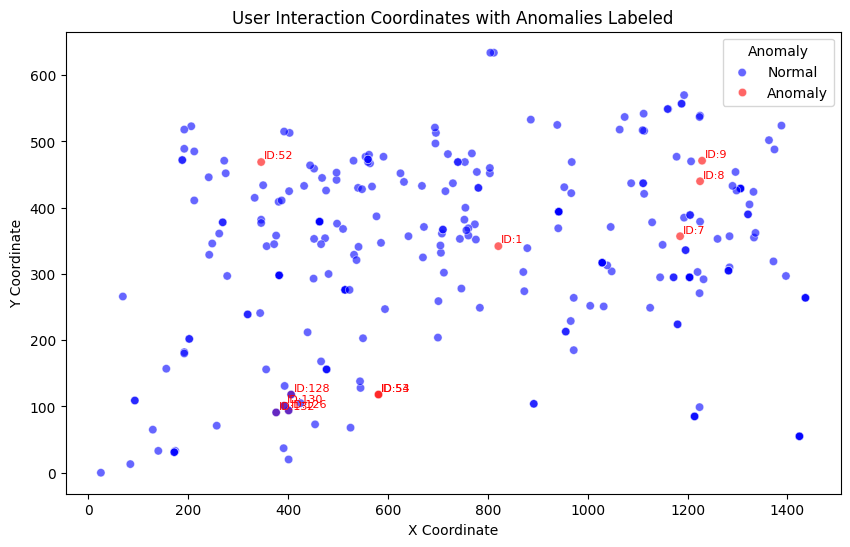

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='x', y='y', hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.6)

# Annotate anomalies
for idx, row in anomalies.iterrows():
    plt.text(row['x'] + 5, row['y'] + 5, f"ID:{idx}", color='red', fontsize=8)

plt.title('User Interaction Coordinates with Anomalies Labeled')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()


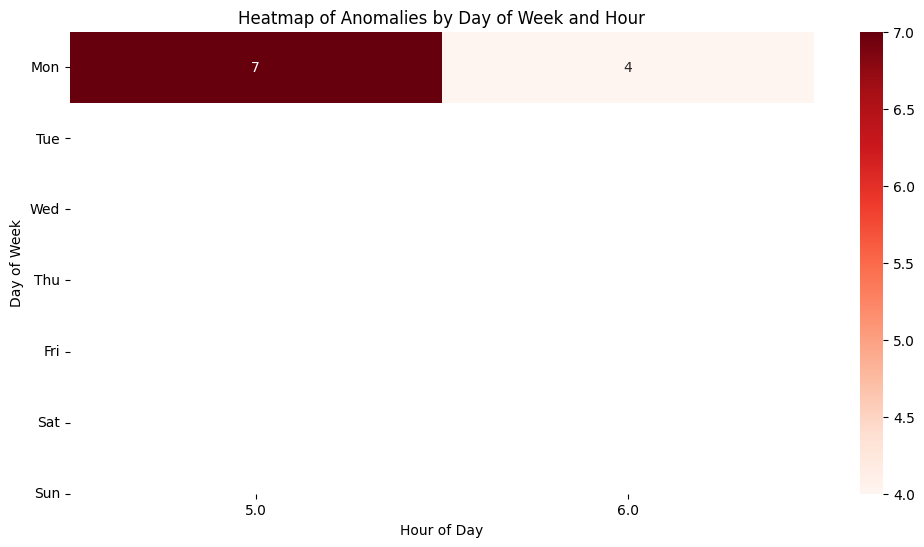

In [29]:
# Create a pivot table for heatmap
import numpy as np
heatmap_data = data.pivot_table(index='day_of_week', columns='hour', 
                                values='anomaly', 
                                aggfunc=lambda x: (x == -1).sum())

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='Reds')
plt.title('Heatmap of Anomalies by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=np.arange(7)+0.5, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Load the CSV
df = pd.read_csv('mapLite_user_activity.csv')

# Fix encoding issues
df['location'] = df['location'].apply(lambda x: x.encode('latin1').decode('utf-8', errors='ignore') if isinstance(x, str) else x)
df['destination'] = df['destination'].apply(lambda x: x.encode('latin1').decode('utf-8', errors='ignore') if isinstance(x, str) else x)
df['inputValue'] = df['inputValue'].apply(lambda x: x.encode('latin1').decode('utf-8', errors='ignore') if isinstance(x, str) else x)

# Handle missing values
categorical_cols = ['event', 'element', 'page', 'relatedElement', 'inputValue', 'location', 'destination']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

numerical_cols = ['x', 'y', 'timeSpent', 'scroll', 'depth', 'timeSpentOnHover']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Convert timestamp to datetime and extract features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['second'] = df['timestamp'].dt.second
df = df.drop('timestamp', axis=1)

# Encode categorical variables
le = LabelEncoder()
for col in ['event', 'element', 'page', 'relatedElement', 'inputValue', 'location', 'destination']:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding
df = pd.get_dummies(df, columns=['event', 'element', 'page', 'relatedElement', 'inputValue', 'location', 'destination'], drop_first=True)

# Feature Scaling
scaler = StandardScaler()
df[numerical_cols + ['hour', 'day', 'month', 'weekday', 'second']] = scaler.fit_transform(df[numerical_cols + ['hour', 'day', 'month', 'weekday', 'second']])

# Prepare features for Isolation Forest
X = df.drop(['anomaly'], axis=1, errors='ignore')  # Adjust if 'anomaly' exists

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X)

# Predict anomalies
df['anomaly'] = iso_forest.predict(X)
anomalies = df[df['anomaly'] == -1]
print(f'Number of anomalies detected: {len(anomalies)}')

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df['pca1'] = X_pca[:,0]
df['pca2'] = X_pca[:,1]

# Plot anomalies
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca1', y='pca2', hue='anomaly', data=df, palette={1: 'blue', -1: 'red'}, alpha=0.5)
plt.title('PCA Projection with Anomalies Highlighted')
plt.show()

# Display some anomalies
print(anomalies.head())


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 6940: invalid continuation byte

In [32]:
import pandas as pd

# Attempt to read with 'latin1' encoding
try:
    df = pd.read_csv('mapLite_user_activity.csv', encoding='latin1')
    print("File read successfully with 'latin1' encoding.")
except UnicodeDecodeError as e:
    print(f"UnicodeDecodeError: {e}")


File read successfully with 'latin1' encoding.


In [34]:
# Attempt to read with 'cp1252' encoding
try:
    df = pd.read_csv('mapLite_user_activity.csv', encoding='cp1252')
    print("File read successfully with 'cp1252' encoding.")
except UnicodeDecodeError as e:
    print(f"UnicodeDecodeError: {e}")


File read successfully with 'cp1252' encoding.
